In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

## Model

In [92]:
class DeepLabV3Model(nn.Module):
    def __init__(self, num_classes=5):
        super(DeepLabV3Model, self).__init__()
        # Load pre-trained DeepLabV3 model
        self.deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)
        # Replace the classifier head to match the number of classes
        self.deeplab.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # The model returns a dict with the output under the key 'out'
        return self.deeplab(x)["out"]

In [3]:
# reusable block: two convolutional layers with Batch Normalization and ReLU
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


# U-Net style model
class SmallUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(SmallUNet, self).__init__()
        # Encoder
        self.conv1 = DoubleConv(in_channels, 16)  # [B, 16, H, W]
        self.pool1 = nn.MaxPool2d(2)  # [B, 16, H/2, W/2]
        self.conv2 = DoubleConv(16, 32)  # [B, 32, H/2, W/2]
        self.pool2 = nn.MaxPool2d(2)  # [B, 32, H/4, W/4]

        # Bottleneck with dropout
        self.bottleneck = nn.Sequential(
            DoubleConv(32, 64),  # [B, 64, H/4, W/4]
            nn.Dropout(0.5),
        )

        # Decoder using ConvTranspose2d for learnable upsampling
        self.up2 = nn.ConvTranspose2d(
            64, 64, kernel_size=2, stride=2
        )  # [B, 64, H/2, W/2]
        self.conv_up2 = DoubleConv(
            64 + 32, 32
        )  # after concatenation: [B, 96, H/2, W/2] -> [B, 32, H/2, W/2]

        self.up1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)  # [B, 32, H, W]
        self.conv_up1 = DoubleConv(
            32 + 16, 16
        )  # after concatenation: [B, 48, H, W] -> [B, 16, H, W]

        # output layer: maps to classes
        self.out_conv = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        c1 = self.conv1(x)  # [B, 16, H, W]
        p1 = self.pool1(c1)  # [B, 16, H/2, W/2]
        c2 = self.conv2(p1)  # [B, 32, H/2, W/2]
        p2 = self.pool2(c2)  # [B, 32, H/4, W/4]

        # Bottleneck
        bn = self.bottleneck(p2)  # [B, 64, H/4, W/4]

        # Decoder path
        u2 = self.up2(bn)  # [B, 64, H/2, W/2]
        # Concatenate skip connection from encoder conv2
        u2 = torch.cat([u2, c2], dim=1)  # [B, 64+32, H/2, W/2]
        c3 = self.conv_up2(u2)  # [B, 32, H/2, W/2]

        u1 = self.up1(c3)  # [B, 32, H, W]
        # Concatenate skip connection from encoder conv1
        u1 = torch.cat([u1, c1], dim=1)  # [B, 32+16, H, W]
        c4 = self.conv_up1(u1)  # [B, 16, H, W]

        out = self.out_conv(c4)  # [B, num_classes, H, W]
        return out

In [4]:
def pad_and_scale_image(image):
    # calculate padding (center the image)
    old_width, old_height = image.size
    max_dim = max(old_width, old_height)
    delta_w = max_dim - old_width
    delta_h = max_dim - old_height

    # padding on each side (left, top, right, bottom)
    padding = (
        delta_w // 2,
        delta_h // 2,
        delta_w - (delta_w // 2),
        delta_h - (delta_h // 2),
    )

    # apply padding
    fill = (0, 0, 0) if image.mode == "RGB" else 0
    padded_img = ImageOps.expand(image, border=padding, fill=fill)

    resized_img = padded_img.resize((224, 224), Image.LANCZOS)

    return resized_img

In [5]:
def pad_and_scale_mask(mask: np.array):
    # calculate padding (center the image)
    old_height, old_width = mask.shape
    max_dim = max(old_width, old_height)
    delta_w = max_dim - old_width
    delta_h = max_dim - old_height

    # padding on each side (left, top, right, bottom)
    padding = (
        delta_w // 2,
        delta_h // 2,
        delta_w - (delta_w // 2),
        delta_h - (delta_h // 2),
    )

    # apply padding
    padded_mask = np.pad(
        mask,
        ((padding[1], padding[3]), (padding[0], padding[2])),
        mode="constant",
        constant_values=0,
    )

    # resize to 224x224
    resized_mask = cv2.resize(padded_mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    return resized_mask

In [6]:
class OpenImagesDataset(Dataset):
    def __init__(
        self,
        root_dir,
        data_split,
        images_meta,
        class_to_idx,
        transform=None,
        target_transform=None,
    ):
        """
        Args:
            root_dir (str): Directory with 'images' and 'masks' subdirectories.
            data_split (str): 'train' or 'val'.
            transform (callable, optional): Optional transform to be applied on the image.
            target_transform (callable, optional): Optional transform to be applied on the mask.
        """
        self.root_dir = root_dir
        self.data_split = data_split
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform

        self.image_dir = os.path.join(root_dir, "images", data_split)
        self.mask_dir = os.path.join(root_dir, "masks", data_split)
        self.image_meta = images_meta

    def __len__(self):
        return len(self.image_meta)

    def __getitem__(self, idx):
        img_id = self.image_meta.index[idx]
        img_meta = self.image_meta.iloc[idx]

        # load input image
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        # load masks
        mask_path = os.path.join(self.mask_dir, img_meta[0][1])
        mask_shape = np.array(Image.open(mask_path)).shape
        img_mask_sum = np.zeros(mask_shape, dtype=np.uint8)

        for class_name, mask_path in img_meta:
            class_idx = self.class_to_idx[class_name]
            mask_path = os.path.join(self.mask_dir, mask_path)
            mask = np.array(Image.open(mask_path), dtype=bool)
            img_mask_sum[mask] = class_idx
        mask = img_mask_sum.astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [18]:
all_images_df = pd.read_csv("../data/meta/all_images.csv", index_col=0)[
    ["MaskPath", "ImageID", "DisplayName", "data_split"]
]

In [19]:
train_images_df = all_images_df.query("data_split == 'train'")
train_images_meta = train_images_df.groupby(["ImageID"]).apply(
    lambda img: [
        (img_class.DisplayName, img_class.MaskPath) for img_class in img.itertuples()
    ],
    include_groups=False,
)

In [32]:
val_images_df = all_images_df.query("data_split == 'validation'")
val_images_meta = val_images_df.groupby(["ImageID"]).apply(
    lambda img: [
        (img_class.DisplayName, img_class.MaskPath) for img_class in img.itertuples()
    ],
    include_groups=False,
)

In [34]:
idx_to_class = dict(enumerate(train_images_df.DisplayName.unique(), start=1))
class_to_idx = {v: k for k, v in idx_to_class.items()}
class_to_idx

{'Bird': 1, 'Cat': 2, 'Dog': 3, 'Person': 4, 'Horse': 5}

### Training setup

In [114]:
# hyperparameters
num_epochs = 10
learning_rate = 1e-3
batch_size = 8

In [116]:
def image_transform(image):
    image = pad_and_scale_image(image)
    image = transforms.ToTensor()(image)
    return image


def target_transform(mask):
    mask = pad_and_scale_mask(mask)
    mask = torch.from_numpy(mask).long()
    return mask


# set the dataset root directory (update with your actual path)
dataset_root = "../data/"
train_dataset = OpenImagesDataset(
    root_dir=dataset_root,
    images_meta=train_images_meta,
    class_to_idx=class_to_idx,
    data_split="train",
    transform=image_transform,
    target_transform=target_transform,
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = OpenImagesDataset(
    root_dir=dataset_root,
    images_meta=val_images_meta,
    class_to_idx=class_to_idx,
    data_split="validation",
    transform=image_transform,
    target_transform=target_transform,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = DeepLabV3Model(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()  # expects raw logits and target of shape (B, H, W)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [140]:
model

DeepLabV3Model(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

### Training loop

In [139]:
model.train()
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for i, (images, masks) in enumerate(tqdm(train_loader), start=1):
        if i == len(train_loader):
            continue
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # outputs: [B, 6, H, W] and masks: [B, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 40 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}] Average Training Loss: {avg_train_loss:.4f}")

    # validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}")

    model.train()  # switch back to training mode for next epoch

print("Training complete.")

  6%|▋         | 40/623 [00:28<06:49,  1.42it/s]

Epoch [1/10], Step [40/623], Loss: 0.3717


 13%|█▎        | 80/623 [00:56<06:21,  1.42it/s]

Epoch [1/10], Step [80/623], Loss: 0.2357


 19%|█▉        | 120/623 [01:23<05:43,  1.46it/s]

Epoch [1/10], Step [120/623], Loss: 0.3432


 26%|██▌       | 160/623 [01:51<05:22,  1.44it/s]

Epoch [1/10], Step [160/623], Loss: 0.1759


 32%|███▏      | 200/623 [02:19<04:50,  1.46it/s]

Epoch [1/10], Step [200/623], Loss: 0.3812


 39%|███▊      | 240/623 [02:47<04:25,  1.44it/s]

Epoch [1/10], Step [240/623], Loss: 0.2386


 45%|████▍     | 280/623 [03:15<03:58,  1.44it/s]

Epoch [1/10], Step [280/623], Loss: 0.2495


 45%|████▌     | 283/623 [03:17<03:57,  1.43it/s]


KeyboardInterrupt: 

In [141]:
batch_masks = masks.cpu().numpy()
batch_outputs = outputs.cpu().detach().numpy()

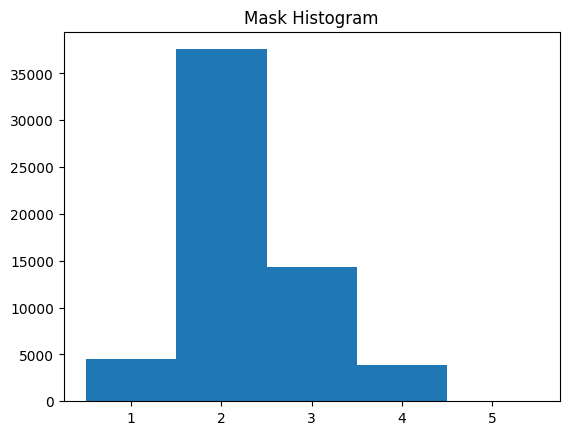

In [149]:
plt.hist(batch_masks[batch_masks > 0].flatten(), bins=5, range=(0.5, 5.5))
plt.title("Mask Histogram")
plt.show()

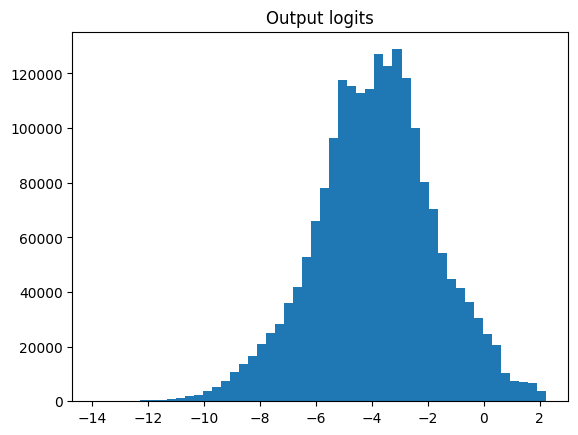

In [150]:
plt.hist(batch_outputs[:, 1:].flatten(), bins=50)
plt.title("Output logits")
plt.show()

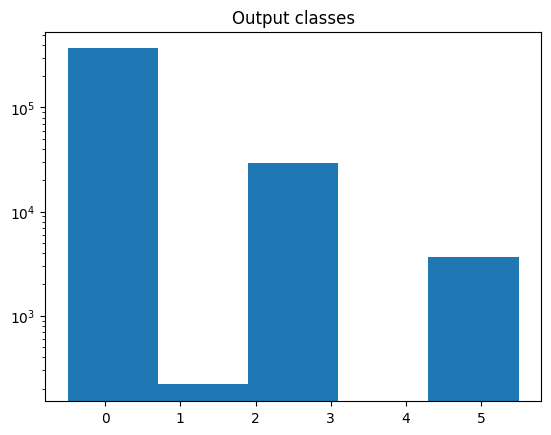

In [151]:
plt.hist(
    np.argmax(batch_outputs, axis=1).flatten(), bins=5, range=(-0.5, 5.5), log=True
)
plt.title("Output classes")
plt.show()

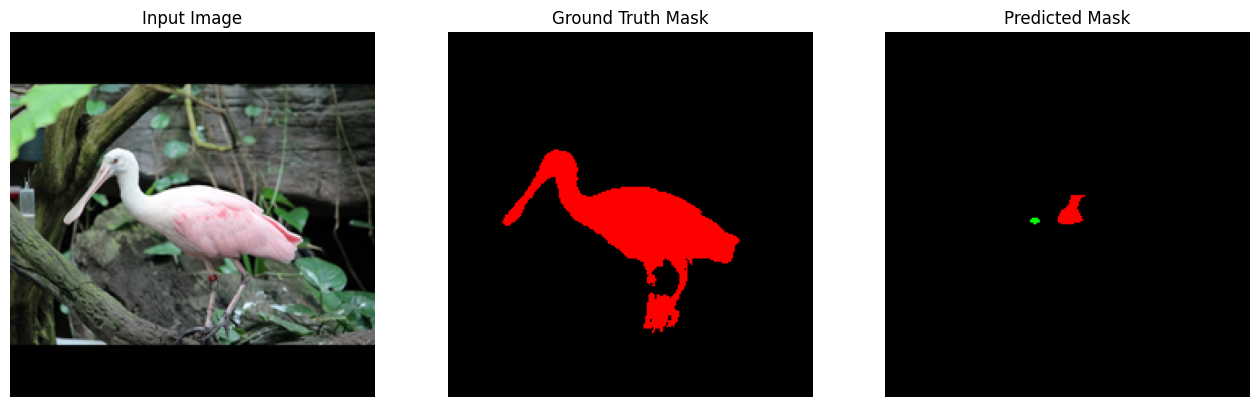

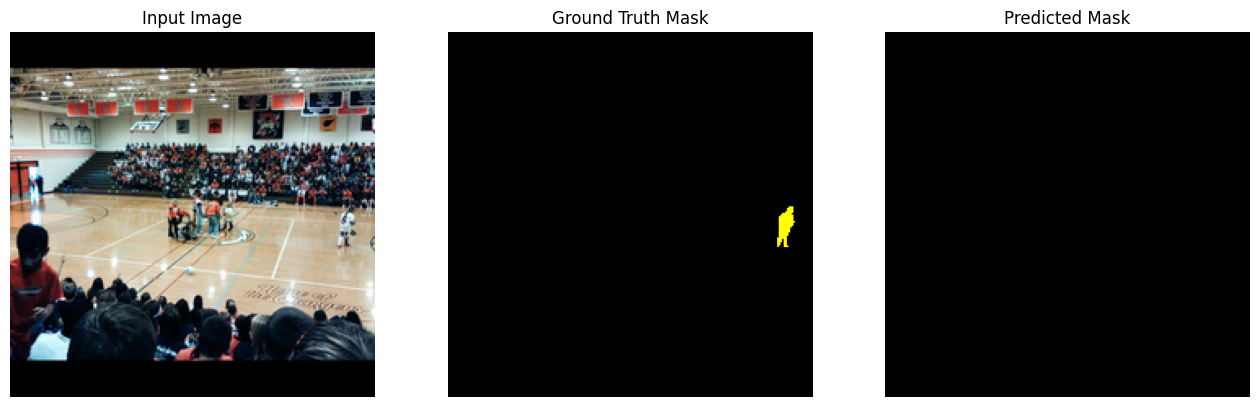

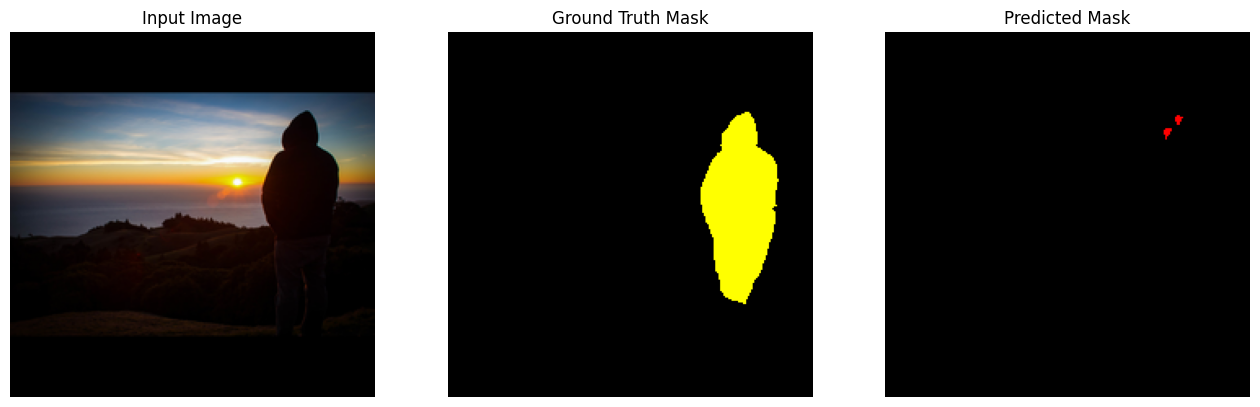

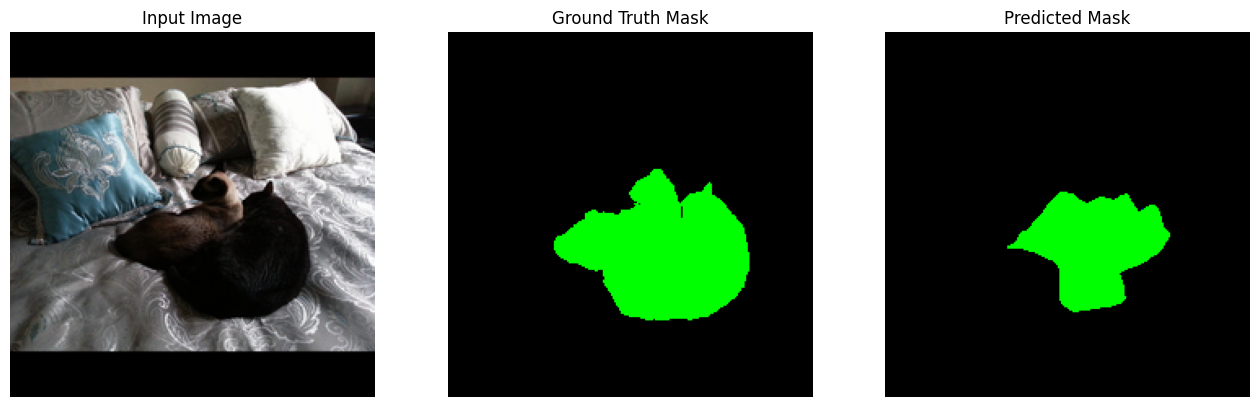

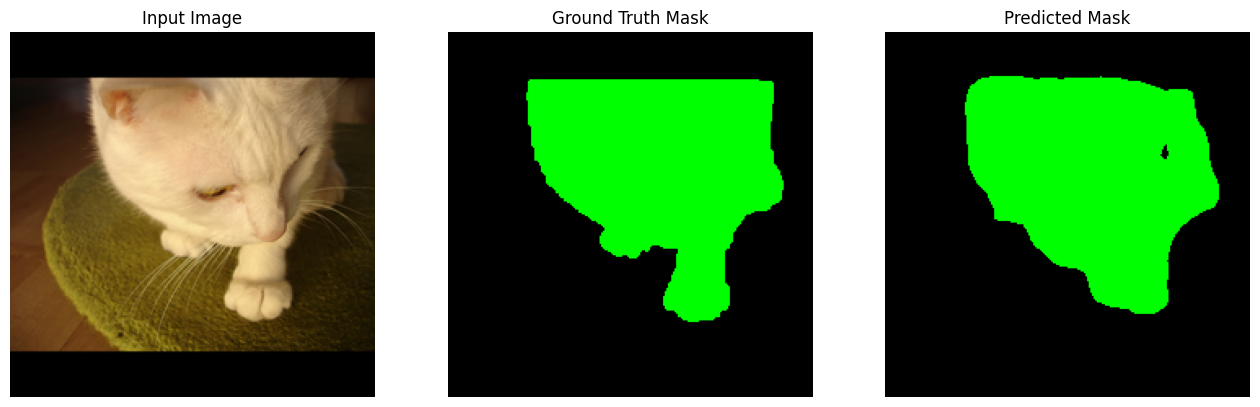

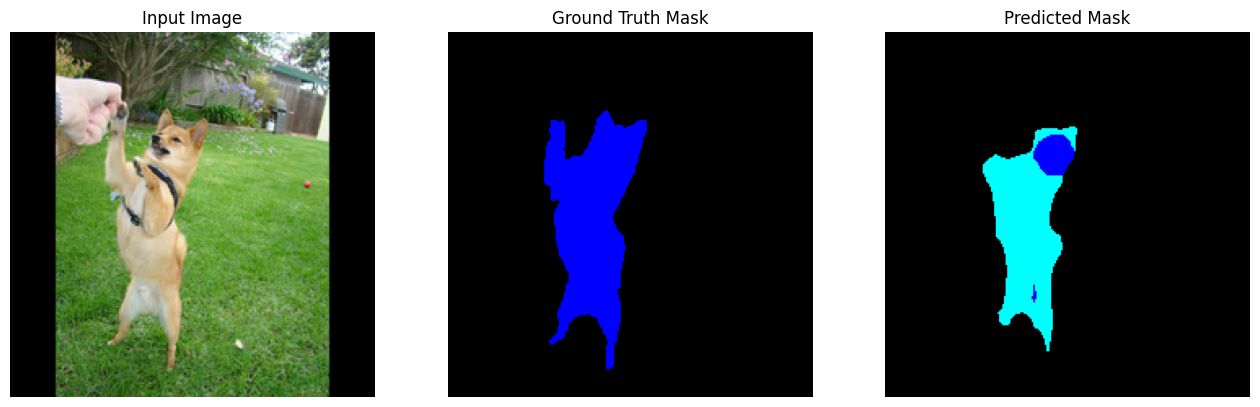

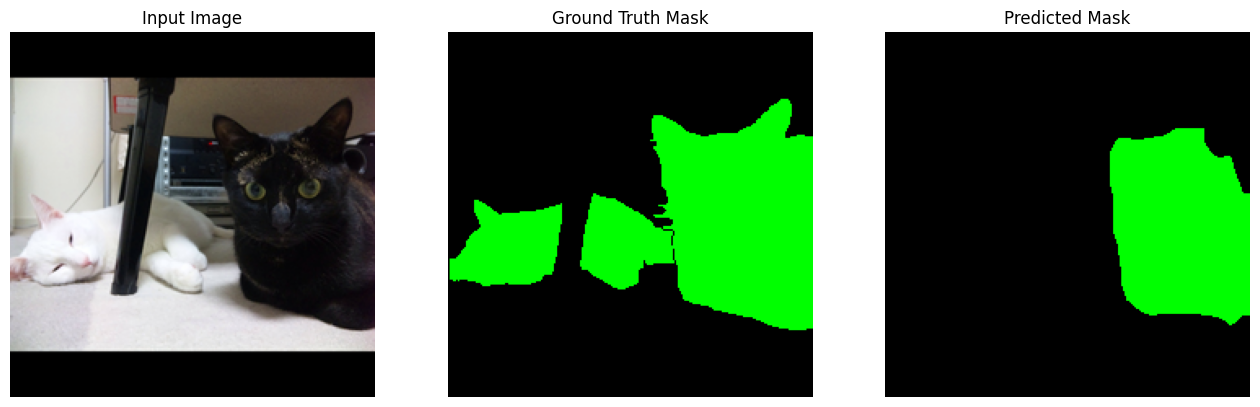

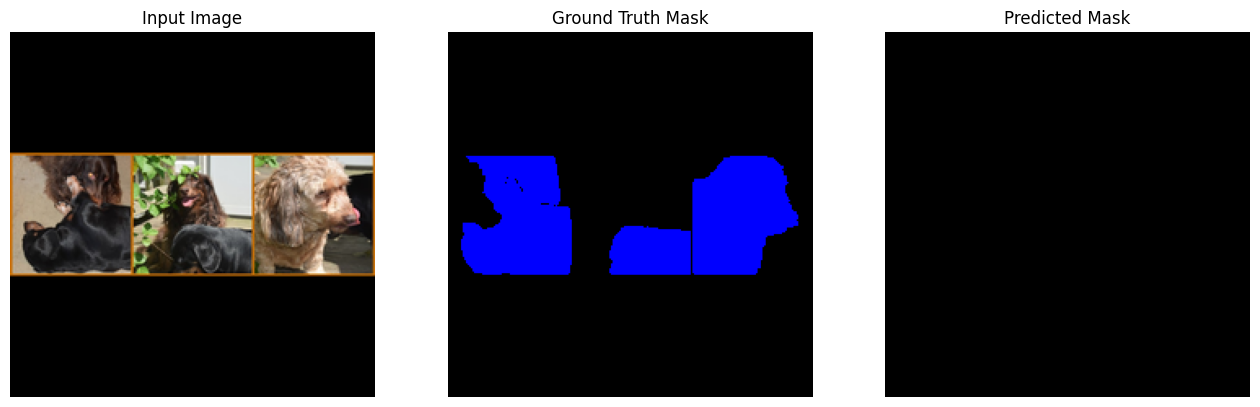

In [152]:
color = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255),
    4: (255, 255, 0),
    5: (0, 255, 255),
}

for idx in range(len(batch_masks)):
    this_mask = batch_masks[idx]
    this_output = batch_outputs[idx]

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(images[idx].cpu().detach().numpy().transpose(1, 2, 0))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    mask_img = np.zeros((*this_mask.shape, 3), dtype=np.uint8)
    for class_idx in range(this_mask.max() + 1):
        mask_img[this_mask == class_idx] = color[class_idx]
    plt.imshow(mask_img)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    predicted_mask = np.argmax(this_output, axis=0)
    predicted_mask_img = np.zeros((*predicted_mask.shape, 3), dtype=np.uint8)
    for class_idx in range(predicted_mask.max() + 1):
        class_mask = predicted_mask == class_idx
        predicted_mask_img[class_mask] = color[class_idx]
    plt.imshow(predicted_mask_img)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

In [250]:
# np.array(Image.open("data/images/validation/078821d86db99fc9.jpg"))

In [273]:
# plt.imshow(Image.open("/home/jupyter/dl_project1/data/masks/train/02ac8e007a385d32_m0cyhj__ad861c39.png"))